# Lab 1
Welcome to Lab 1. 

Using Open-source UCI repository dataset, we will train the model of breast cancer detection. K-nearest neighborhood and Support Vector Machine will be used. In this data, the goal is to predict malignant or benign based on some features.

This is a introduction to the process of how to train a model in Python. 


## Required Packages

In [1]:
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from pandas.plotting import scatter_matrix

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Version Check

In [2]:
print('Python: {}'.format(sys.version))
print('Numpy: {}'.format(np.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Pandas: {}'.format(pd.__version__))
print('Scikit-learn: {}'.format(sklearn.__version__))

Python: 3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]
Numpy: 1.22.4
Matplotlib: 3.8.0
Pandas: 2.1.1
Scikit-learn: 1.3.2


# Supervised Learning

## Dataset Load
More data information is in [here](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)
We will just be using the dataset in memory for this lab. 

We are removing any rows with missing values. This is one way to handling missing data, another option is to replace with a value such as the average, it depends on the data itself and you can do some exploration around how you wish to handle missing data. 

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
names = ['id', 'clump_thickness', 'uniform_cell_size', 'uniform_cell_shape', 
         'marginal_adhesion', 'single_epithelial_size', 'bare_nuclei',
         'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class']

df = pd.read_csv(url, names=names).replace('?', np.nan).dropna()

In [4]:
df.head()

,id,clump_thickness,uniform_cell_size,uniform_cell_shape,marginal_adhesion,single_epithelial_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


## Preprocess data

We are removing 'ID' as it is not a useful feature, it's unique and doesn't contain any relevent information in the model but could add bias. 

In [5]:
# Drop useless feature for classification
df.drop(['id'], axis=1, inplace=True)

## Summarize Dataset

Often a good first step when you get your data is to visualise it. Below we are doing this in two ways, one the summary statistics of the columns and secondly plotting a histogram of the values. All of our data is numeric, if we had categorical data we would have different approaches.

In [6]:
print(df.describe())

       clump_thickness  uniform_cell_size  uniform_cell_shape  \
count       683.000000         683.000000          683.000000   
mean          4.442167           3.150805            3.215227   
std           2.820761           3.065145            2.988581   
min           1.000000           1.000000            1.000000   
25%           2.000000           1.000000            1.000000   
50%           4.000000           1.000000            1.000000   
75%           6.000000           5.000000            5.000000   
max          10.000000          10.000000           10.000000   

       marginal_adhesion  single_epithelial_size  bland_chromatin  \
count         683.000000              683.000000       683.000000   
mean            2.830161                3.234261         3.445095   
std             2.864562                2.223085         2.449697   
min             1.000000                1.000000         1.000000   
25%             1.000000                2.000000         2.000000   


To see how the values interact with each other we have created a scatter plot. 

## Split Train/Test data

Now to start training. 

We first have to split the data into the data without the target varible and the target variable (class).

Next create a train set, which will be used during the model training and a test set which will be used to check how the model performed. We do this as we want to 'test' how the model performs on data it has not seen before. For our set we are doing a 80:20 split of the data. 

In [7]:
X = df.drop(['class'], axis=1).to_numpy()
y = df['class'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Specify Test options

For different algorithms and use cases you can set metrics which you want your model to be measured against, for us we are doing a classification task so a useful metric is 'accuracy'. 

Accuracy is defined as (number of correctly predicted)/(total number of prediction), so it is a value between 0 and 1. 

A seed is set to ensure reproducibility of your models. A random seed is a number (or vector) used to initialize a pseudorandom number generator, this ensures that if someone uses the same seed as you they should see the same results.  

In [8]:
seed = 8
scoring = 'accuracy'
#other options for scoring are ‘f1’, 'precision', 'recall', change the value above to see what impact it makes 
#also change the seed to see the impact

## Define the model to train

For this lab we are using the K Nearest Neighbour and Support Vector Machine algorithms. It's common to use multiple algorithms to see which performs best on your data. 

Cross validation, (cross_val_score in the code) is a resampling method that uses different portions of the data to test and train a model on different iterations. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice.

In [9]:
models = []
models.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
models.append(('SVM', SVC()))

# Evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.970808 (0.020193)
SVM: 0.963468 (0.026901)


## Make Predictions on validation dataset

Ok so accuracy looks pretty good, KNN performing better than SVM, let's now make some predictions. Using the test data we will be using the models we trained to make some predicions and then see the performance.

In the classification report we can see other metrics such as precision, recall, f1-score. Feel free to read up on what these mean/measure. 

On the predictions SVM has improved, but KNN still performs best. 

In [10]:
from sklearn.metrics import confusion_matrix

for name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(name)
    print(accuracy_score(y_test, predictions))
    print(classification_report(y_test, predictions))
    print('Confusion Matrix')
    print(confusion_matrix(y_test, predictions))

KNN
0.9854014598540146
              precision    recall  f1-score   support

           2       0.99      0.99      0.99        93
           4       0.98      0.98      0.98        44

    accuracy                           0.99       137
   macro avg       0.98      0.98      0.98       137
weighted avg       0.99      0.99      0.99       137

Confusion Matrix
[[92  1]
 [ 1 43]]
SVM
0.9781021897810219
              precision    recall  f1-score   support

           2       0.99      0.98      0.98        93
           4       0.96      0.98      0.97        44

    accuracy                           0.98       137
   macro avg       0.97      0.98      0.98       137
weighted avg       0.98      0.98      0.98       137

Confusion Matrix
[[91  2]
 [ 1 43]]


## Another way to get accuracy

Another way to train a model is using the fit, and score function from the model libaries. Fit the model on the training data, then run the test data through the model and seee the accuracy. 

In [11]:
clf = SVC()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

0.9781021897810219


Complete the below code to train a KNN model.
Review https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html for the code 

In [12]:
clf = #ENTER KNN CODE
clf.fit(#enter x and y)
accuracy = clf.score(#enter x and y)
print(accuracy)

SyntaxError: invalid syntax (3009078077.py, line 1)

## Test it with samples

Create your own example data to see how it performs. 

In [13]:
example = np.array([[4, 2, 1, 1, 1, 2, 3, 2, 10]])
example = example.reshape(len(example), -1)
prediction = clf.predict(example)
print(prediction)

[2]


In [14]:
example = np.array([[10, 2, 1, 1, 1, 2, 3, 2, 10]])
example = example.reshape(len(example), -1)
prediction = clf.predict(example)
print(prediction)

[4]


## Some other useful tools 

Just some examples of important concepts in Machine Learning

#### Underfitting vs Overfitting 

This example demonstrates the problems of underfitting and overfitting and how we can use linear regression with polynomial features to approximate nonlinear functions. The plot shows the function that we want to approximate, which is a part of the cosine function. In addition, the samples from the real function and the approximations of different models are displayed. The models have polynomial features of different degrees. We can see that a linear function (polynomial with degree 1) is not sufficient to fit the training samples. This is called underfitting. A polynomial of degree 4 approximates the true function almost perfectly. However, for higher degrees the model will overfit the training data, i.e. it learns the noise of the training data. We evaluate quantitatively overfitting / underfitting by using cross-validation. We calculate the mean squared error (MSE) on the validation set, the higher, the less likely the model generalizes correctly from the training data.

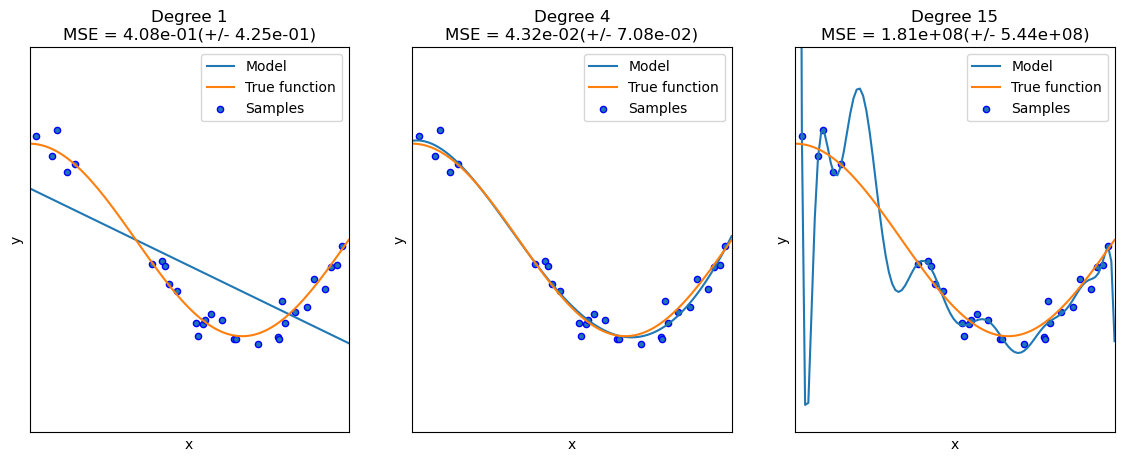

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)


np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
            degrees[i], -scores.mean(), scores.std()
        )
    )
plt.show()

# Unsupervised Learning

['DESCR', 'data', 'data_module', 'feature_names', 'filename', 'frame', 'target', 'target_names']
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
['setosa' 'versicolor' 'virginica']


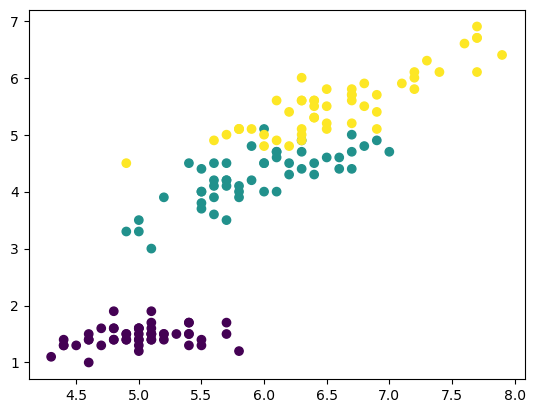

In [16]:
# Importing Modules
from sklearn import datasets
import matplotlib.pyplot as plt

# Loading dataset
iris_df = datasets.load_iris()

# Available methods on dataset
print(dir(iris_df))

# Features
print(iris_df.feature_names)

# Targets
print(iris_df.target)

# Target Names
print(iris_df.target_names)
label = {0: 'red', 1: 'blue', 2: 'green'}

# Dataset Slicing
x_axis = iris_df.data[:, 0]  # Sepal Length
y_axis = iris_df.data[:, 2]  # Sepal Width

# Plotting
plt.scatter(x_axis, y_axis, c=iris_df.target)
plt.show()

### K Means Clustering 

The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares (see below). This algorithm requires the number of clusters to be specified. It scales well to large numbers of samples and has been used across a large range of application areas in many different fields.

For the iris example, we know there are 3 types, but sometimes you don't know and clustering can help you find distinct groups in the dataset. 


In [17]:
# Importing Modules
from sklearn import datasets
from sklearn.cluster import KMeans

# Loading dataset
iris_df = datasets.load_iris()

# Declaring Model
model = KMeans(n_clusters=3)

# Fitting Model
model.fit(iris_df.data)



/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3)

In [18]:
# Predicitng a single input
predicted_label = model.predict([[7.2, 3.5, 0.8, 1.6]])

# Prediction on the entire data
all_predictions = model.predict(iris_df.data)

# Printing Predictions
print(predicted_label)
print(all_predictions)

[0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]


### Principle Component Analysis

The Iris dataset represents 3 kind of Iris flowers (Setosa, Versicolour and Virginica) with 4 attributes: sepal length, sepal width, petal length and petal width.

Principal Component Analysis (PCA) applied to this data identifies the combination of attributes (principal components, or directions in the feature space) that account for the most variance in the data. Here we plot the different samples on the 2 first principal components.

Linear Discriminant Analysis (LDA) tries to identify attributes that account for the most variance between classes. In particular, LDA, in contrast to PCA, is a supervised method, using known class labels.

[Further Reading](https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py) 

explained variance ratio (first two components): [0.92461872 0.05306648]


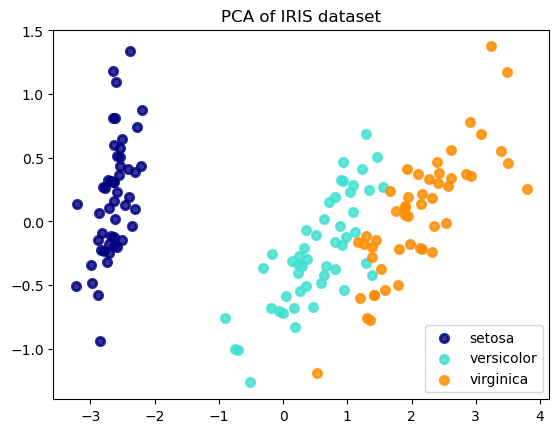

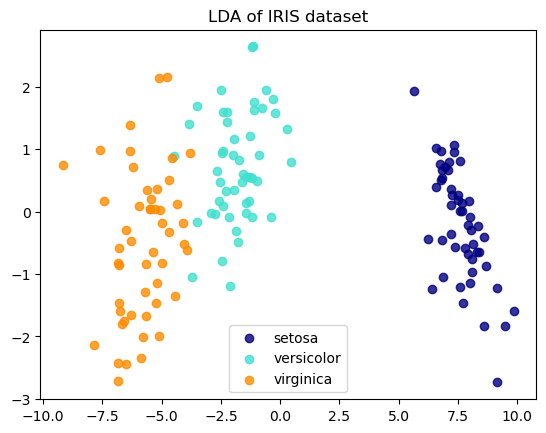

In [19]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

# Percentage of variance explained for each components
print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of IRIS dataset")

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r2[y == i, 0], X_r2[y == i, 1], alpha=0.8, color=color, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of IRIS dataset")

plt.show()